root
 |-- faa: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- alt: integer (nullable = true)
 |-- tz: integer (nullable = true)
 |-- dst: string (nullable = true)

+---+--------------------+----------+-----------+----+---+---+
|faa|                name|       lat|        lon| alt| tz|dst|
+---+--------------------+----------+-----------+----+---+---+
|04G|   Lansdowne Airport|41.1304722|-80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|32.4605722|-85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|41.9893408|-88.1012428| 801| -6|  A|
|06N|     Randall Airport| 41.431912|-74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|31.0744722|-81.4277778|  11| -4|  A|
+---+--------------------+----------+-----------+----+---+---+
only showing top 5 rows

+---+-----+
| tz|count|
+---+-----+
| -5|  450|
| -6|  312|
| -9|  222|
| -7|  161|
| -8|  152|
| -4|   66|
|-10|   26|
|-11|    2|
|  5|    2|
|  8|    2|

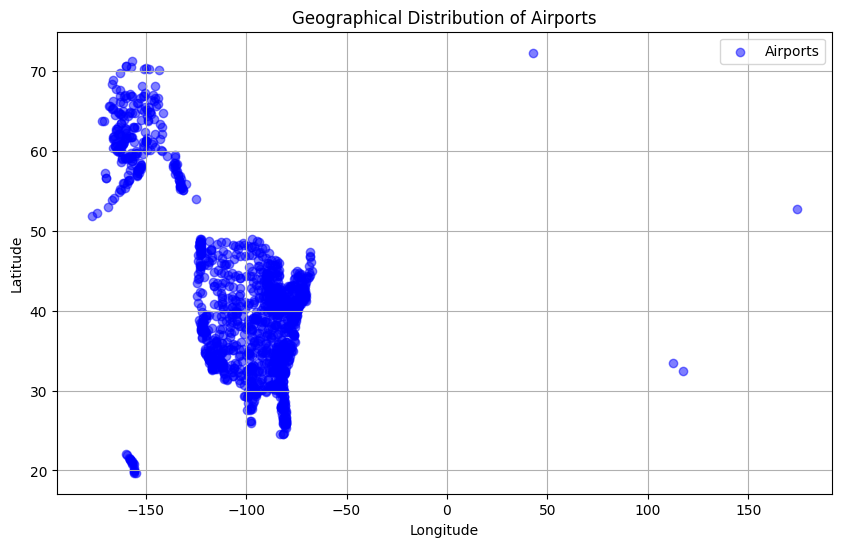

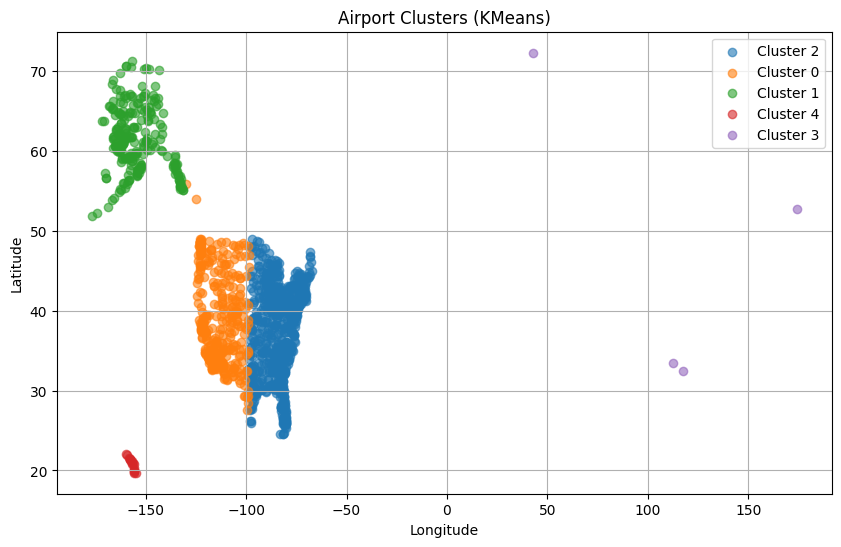

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AirportDataAnalysis") \
    .getOrCreate()


# Load the airport dataset from a CSV file with headers and inferred schema
df = spark.read.option("header", True).csv("/content/airports data.csv", inferSchema=True)

# Display the schema to understand data types of each column
df.printSchema()

# Display first 5 records for a quick look at the dataset
df.show(5)

# 1. Aggregation: Number of airports by time zone
tz_counts = df.groupBy("tz").count().orderBy(desc("count"))  # Group by time zone and count airports
tz_counts.show()  # Show time zones sorted by airport count

# 2. Find airports at the highest and lowest altitudes

# Top 5 highest altitude airports
print("Highest Altitude Airports:")
df.orderBy(desc("alt")).select("faa", "name", "alt").show(5)

# Top 5 lowest altitude airports
print("Lowest Altitude Airports:")
df.orderBy("alt").select("faa", "name", "alt").show(5)

# 3. Count of airports per DST (Daylight Saving Time) category
dst_counts = df.groupBy("dst").count().orderBy(desc("count"))  # Group by DST category
dst_counts.show()  # Show counts sorted in descending order

# Convert Spark DataFrame to Pandas for visualization
pdf = df.select("lat", "lon", "alt", "tz", "dst").toPandas()  # Select relevant columns and convert


# Visualization: Scatter plot of airport coordinates
plt.figure(figsize=(10, 6))
plt.scatter(pdf['lon'], pdf['lat'], alpha=0.5, c='blue', label='Airports')  # Plot longitude vs latitude
plt.title("Geographical Distribution of Airports")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


# Clustering: Apply KMeans to group airports by location
# Prepare coordinate data by removing missing values
coords = pdf[["lat", "lon"]].dropna()

# Apply KMeans clustering to latitude and longitude with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42).fit(coords)

# Add cluster labels to the coordinates DataFrame
coords["cluster"] = kmeans.labels_

# Visualization: Plot the clusters on a scatter plot
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster in coords["cluster"].unique():
    cluster_data = coords[coords["cluster"] == cluster]
    plt.scatter(cluster_data["lon"], cluster_data["lat"], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Airport Clusters (KMeans)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


# Clean-up: Stop the Spark session
spark.stop()
